# xcube GEDI Data Store using `bbox`

This notebook provides a walk-through demonstrating how to use the xcube-gedi plugin to read and explore data from the GEDI API using the `gedidb` pacakge.

The `gedidb` package allows to query the data as xarray datasets in two modes: `bounding_box` where need to provide a bbox and `nearest` where we need to provide a point.

This notebook shows how to access this store using `bbox`

In [1]:
%%time
from xcube.core.store import new_data_store
import logging

CPU times: user 2.45 s, sys: 263 ms, total: 2.71 s
Wall time: 1.32 s


In [2]:
store = new_data_store("gedi")

We can set the logging level here for this plugin as follows:

In [3]:
logging.getLogger("xcube.gedi").setLevel(logging.INFO)

In this data store, we are defining the data_ids as the processed level datasets that are available via [gedidb](/https://gedidb.readthedocs.io/).

These data_ids have no attributes and it will return an empty dict when requested with `include_attrs`

In [4]:
store.list_data_ids()

['L4A', 'L2B', 'L2A', 'L4C', 'all']

In [5]:
store.list_data_ids(include_attrs=True)

2025-06-05 14:47:38,349 - WARNING - There are no attributes for data_ids in this data store


[('L4A', {}), ('L2B', {}), ('L2A', {}), ('L4C', {}), ('all', {})]

This data store has no credentials required to access data hence the data store initialization is the leanest and you just need to provide the name of the data store which is `gedi` to the `new_data_store()` method.

In [6]:
store.get_data_store_params_schema()

2025-06-05 14:47:38,353 - INFO - This data store can be initialized without any params


You can also look at the data description for each level. We get this information from the [NASA CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html)

Although, it is not retrievable via API, after reading the documentation for these datasets supported by `gedidb`, the `CRS` for all these data_ids is `EPSG:4326`. 

Links to documentation sources:

- [https://docs.terrabyte.lrz.de/datasets/gedi/introduction/](https://docs.terrabyte.lrz.de/datasets/gedi/introduction/)
- [https://lpdaac.usgs.gov/products/gedi02_av002/](https://lpdaac.usgs.gov/products/gedi02_av002/)
- [https://lpdaac.usgs.gov/documents/986/GEDI02_UserGuide_V2.pdf](https://lpdaac.usgs.gov/documents/986/GEDI02_UserGuide_V2.pdf)
- [https://lpdaac.usgs.gov/products/gedi02_bv002/](https://lpdaac.usgs.gov/products/gedi02_bv002/)


In [7]:
store.describe_data("L4A")

The error below is expected and it explains why. This is just FYI

In [8]:
store.describe_data("all")

ValueError: `all` is just a placeholder to allow users to choose variables from various levels into a single data cube. Please provide a valid data_id (level_name) instead

To open a dataset from this store, you would need to provide the `data_id`, and the `variables` that you need from that `data_id`. If you want to mix different variables from various levels use `all` as data_id as shown in the example a few cells below.

To find the variables, you can either provide the data_id or not at all. The variables will be then filtered based on your input.

In the output `JSONSchema` below, you can expand into `properties.variables.enum` to get all the variables and its description separated by `:`.

The variable name that you should use is the one that comes before `:`, for e.g. `"agbd: Aboveground biomass density"`, here the variable name is `agbd`.

In [9]:
store.get_open_data_params_schema()

There is also a class variable which returns all the available variables as the pandas 

In [10]:
store.all_supported_variables

,description,dtype,product_level,units,profile_length
agbd,Aboveground biomass density,float32,L4A,Mg/ha,NaN
agbd_pi_lower,Lower prediction interval for aboveground biom...,float32,L4A,Mg/ha,NaN
agbd_pi_upper,Upper prediction interval for aboveground biom...,float32,L4A,Mg/ha,NaN
agbd_se,Standard error of aboveground biomass density,float32,L4A,Mg/ha,NaN
agbd_t,Model prediction in fit units,float32,L4A,adimensional,NaN
...,...,...,...,...,...
wsci_xy_pi_upper,Horizontal Structural Complexity upper predict...,float32,L4C,adimensional,NaN
wsci_z,Vertical Structural Complexity,float32,L4C,adimensional,NaN
wsci_z_pi_lower,Vertical Structural Complexity lower predictio...,float32,L4C,adimensional,NaN
wsci_z_pi_upper,Vertical Structural Complexity upper predictio...,float32,L4C,adimensional,NaN


As there are no opener IDS, you will get the following expected error when calling this method

In [11]:
store.get_data_opener_ids()

NotImplementedError: Since we use gedidb to request the data, which has already been converted from HDF5 to TileDB arrays, there are no data opener IDs available. The open_data() method always returns an xarray object.

You can check the type of data that is returned from the `open_data()` method.

In [12]:
store.get_data_types()

('dataset',)

In [13]:
store.get_data_types_for_data('L4C')

('dataset',)

NOTE: Please keep in mind, that there are several assertions in the open_data to make sure that the expected parameters are passed. One example can be seen below:

In [14]:
%%time
ds = store.open_data(
            data_id="L2B",
            bbox=(-112.30, 50.63, -112.0, 50.75),
            start_time="2023-01-26",
            end_time="2023-01-30",
        )
ds

AssertionError: Variables are missing.

Now, let us use the `open_data` method to open a dataset for `L4C` and the variable `wsci` and other parameters as you can see below.

In [15]:
%%time

bbox = (30.256673359035123, -15.85375449790373, 30.422423359035125, -15.62525449790373)
vars_selected = ["wsci"]
start_time = "2023-01-01"
end_time = "2024-07-02"

gedi_data = store.open_data(
    data_id="L4C",
    variables=vars_selected,
    query_type="bounding_box",
    bbox=bbox,
    start_time=start_time,
    end_time=end_time,
    return_type='xarray'
)

CPU times: user 1.27 s, sys: 3.48 s, total: 4.75 s
Wall time: 7.04 s


In [16]:
gedi_data

<xarray.Dataset> Size: 90kB
Dimensions:      (shot_number: 2492)
Coordinates:
  * shot_number  (shot_number) uint64 20kB 234630100400367828 ... 23463000040...
    latitude     (shot_number) float64 20kB -15.8 -15.8 -15.8 ... -15.75 -15.75
    longitude    (shot_number) float64 20kB 30.34 30.34 30.34 ... 30.31 30.31
    time         (shot_number) datetime64[ns] 20kB 2023-02-02 ... 2023-02-02
Data variables:
    wsci         (shot_number) float32 10kB 7.873 8.903 7.986 ... 10.15 10.28

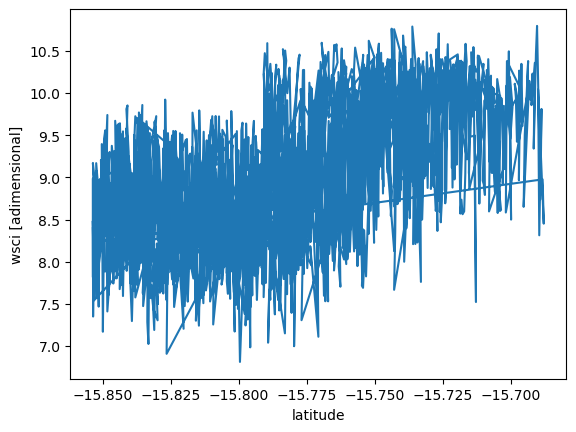

In [17]:
gedi_data.wsci.plot(x='latitude')

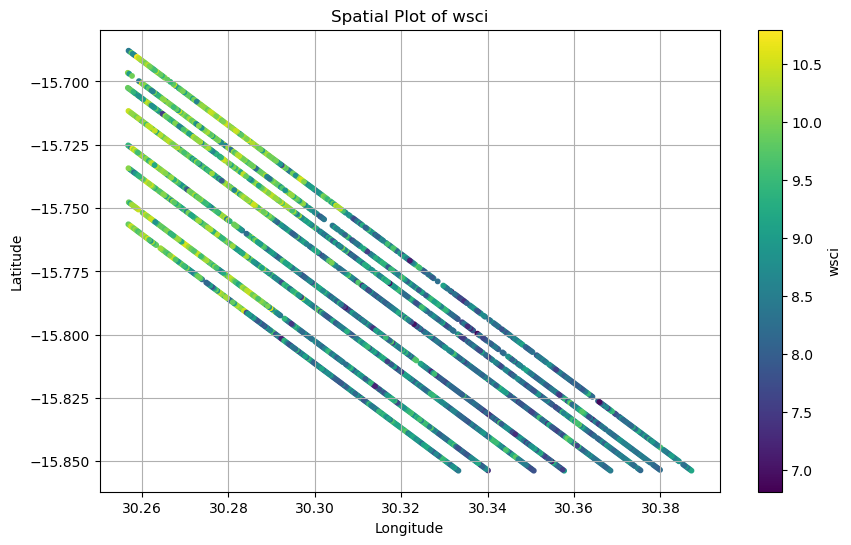

In [18]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['wsci'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='wsci')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of wsci')
plt.grid(True)
plt.show()

Now let us also include a variable from `L2A`, to do that, use `data_id="all"`

In [19]:
%%time

bbox = (30.256673359035123, -15.85375449790373, 30.422423359035125, -15.62525449790373)
vars_selected = ["wsci", "agbd"]
start_time = "2023-01-01"
end_time = "2024-07-02"

gedi_data = store.open_data(
    data_id="all",
    variables=vars_selected,
    query_type="bounding_box",
    bbox=bbox,
    start_time=start_time,
    end_time=end_time,
    return_type='xarray'
)

CPU times: user 1.65 s, sys: 4.86 s, total: 6.5 s
Wall time: 9.32 s


In [20]:
gedi_data

<xarray.Dataset> Size: 100kB
Dimensions:      (shot_number: 2492)
Coordinates:
  * shot_number  (shot_number) uint64 20kB 234630100400367828 ... 23463000040...
    latitude     (shot_number) float64 20kB -15.8 -15.8 -15.8 ... -15.75 -15.75
    longitude    (shot_number) float64 20kB 30.34 30.34 30.34 ... 30.31 30.31
    time         (shot_number) datetime64[ns] 20kB 2023-02-02 ... 2023-02-02
Data variables:
    agbd         (shot_number) float32 10kB 11.37 40.87 7.68 ... 119.5 149.7
    wsci         (shot_number) float32 10kB 7.873 8.903 7.986 ... 10.15 10.28

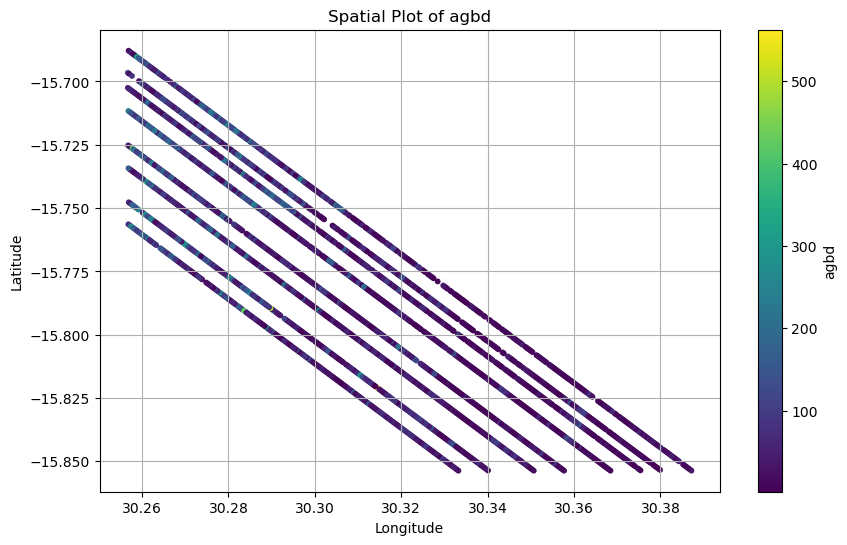

In [21]:
lat = gedi_data['latitude'].values
lon = gedi_data['longitude'].values
agbd = gedi_data['agbd'].values


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sc = plt.scatter(lon, lat, c=agbd, cmap='viridis', s=10)
plt.colorbar(sc, label='agbd')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot of agbd')
plt.grid(True)
plt.show()